# DQN Trading System - Main Orchestration Notebook

This notebook orchestrates the complete DQN trading workflow:
1. Data collection and preprocessing (one-time per project)
2. Training for each strategy config
3. Out-of-sample validation comparison across all strategies
4. Final test comparison across all strategies

In [1]:
# Setup and imports
import sys
import os
import json
import glob
import warnings
warnings.filterwarnings('ignore')

# Import modules
from src.utils.config_loader import ConfigLoader
from src.utils.model_manager import ModelManager
from src.utils.progress_logger import ProgressLogger
from src.data.collector import DataCollector
from src.data.splitter import DataSplitter
from src.features.engineer import FeatureEngineer
from src.features.normalizer import RollingNormalizer
from src.trading.environment import TradingEnvironment
from src.training.trainer import DQNTrainer
from src.evaluation.validator import OutOfSampleValidator
from src.evaluation.metrics import PerformanceMetrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML, clear_output
import time
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
%matplotlib inline

TensorFlow version: 2.12.0


## 1. Configuration

### Project Folder Structure:
- Each project folder contains:
  - `data_config.json` - Data settings, ticker, dates, validation/test splits
  - `trading_*.json` - One or more trading strategy configs

### Available Projects:
- `dry_run` - Quick test (1 episode, 2 years data)
- `default_run` - Full training (100 episodes, 10 years data)

### Test Mode:
- `test_mode=True` - Skip training if models exist, otherwise assert
- `test_mode=False` - Always perform training

In [2]:
# ========== CONFIGURATION ==========
PROJECT_FOLDER = 'my_project'  # Options: 'dry_run', 'default_run', or custom folder name
TEST_MODE = False  # If True, skip training if models exist (for testing only)
# ===================================

# Build paths
project_path = f'config/{PROJECT_FOLDER}'
data_config_path = f'{project_path}/data_config.json'

# Verify project folder exists
if not os.path.exists(project_path):
    raise ValueError(f"Project folder not found: {project_path}")

if not os.path.exists(data_config_path):
    raise ValueError(f"Data config not found: {data_config_path}")

# Load data config
data_config = ConfigLoader(data_config_path)

# Find all trading config files
trading_configs_paths = glob.glob(f'{project_path}/trading_*.json')
if not trading_configs_paths:
    raise ValueError(f"No trading configs found in {project_path}/")

# Sort for consistent ordering
trading_configs_paths.sort()

# Load all trading configs
trading_configs = []
for path in trading_configs_paths:
    with open(path, 'r') as f:
        tc = json.load(f)
        trading_configs.append({
            'path': path,
            'config': tc,
            'strategy_name': tc.get('strategy_name', tc.get('experiment_name', 'Unnamed')),
            'experiment_name': tc.get('experiment_name', os.path.basename(path).replace('.json', ''))
        })

# Initialize run
ticker = data_config.config['ticker']
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = f"{PROJECT_FOLDER}_{ticker}_{timestamp}"
logger = ProgressLogger(run_name=run_name, log_dir=f"logs/{PROJECT_FOLDER}")

# Create results directory early for saving plots
results_dir = f"results/{PROJECT_FOLDER}/run_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

print(f"🚀 DQN Trading System")
print(f"{'='*70}")
print(f"📁 Project: {PROJECT_FOLDER}")
print(f"📊 Ticker: {ticker}")
print(f"📅 Date range: {data_config.config['start_date']} to {data_config.config['end_date']}")
print(f"🎯 Strategies: {len(trading_configs)}")
for i, tc in enumerate(trading_configs, 1):
    print(f"   {i}. {tc['strategy_name']} ({tc['experiment_name']})")
print(f"🧪 Test mode: {'ON' if TEST_MODE else 'OFF'}")
print(f"📝 Run name: {run_name}")
print(f"📂 Results will be saved to: {results_dir}")
print(f"{'='*70}")
print(f"\nMonitor this run: python monitor_training.py --run {run_name}")

[2026-01-19 09:20:18] Initialized - Run: default_run_SPY_20260119_092018
🚀 DQN Trading System
📁 Project: default_run
📊 Ticker: SPY
📅 Date range: 2023-01-01 to 2025-12-31
🎯 Strategies: 2
   1. Baseline (20% SL/TP) (baseline)
   2. No Guardrails (no_guardrails)
🧪 Test mode: OFF
📝 Run name: default_run_SPY_20260119_092018
📂 Results will be saved to: results/default_run/run_20260119_092018

Monitor this run: python monitor_training.py --run default_run_SPY_20260119_092018


## 2. Data Collection (One-Time)

In [3]:
# Collect data once for all strategies
logger.start_stage("Data Collection", f"Collecting {ticker} and VIX data")

collector = DataCollector(data_config.config)
spy_data, vix_data = collector.collect_data(force_download=False)

info = collector.get_data_info(spy_data, vix_data)
logger.complete_stage("Data Collection", info)

print("✅ Data Collection Summary:")
for key, value in info.items():
    print(f"  {key}: {value}")

[2026-01-19 09:20:18] Starting: Data Collection - Collecting SPY and VIX data
YF.download() has changed argument auto_adjust default to True
  Saved 924 records to SPY_20220426_20251230.csv
  Saved 924 records to VIX_20220426_20251230.csv
[2026-01-19 09:20:19] Completed: Data Collection - Duration: 0.8s
✅ Data Collection Summary:
  SPY_records: 924
  SPY_start: 2022-04-26
  SPY_end: 2025-12-30
  vix_records: 924
  vix_start: 2022-04-26
  vix_end: 2025-12-30


## 3. Feature Engineering

In [4]:
# Combine data and create features
logger.start_stage("Feature Engineering", f"Creating technical indicators and features")

combined_data = collector.combine_data(spy_data, vix_data)
print(f"Combined data shape: {combined_data.shape}")

engineer = FeatureEngineer(data_config.config)
featured_data = engineer.create_features(combined_data)

feature_columns = engineer.get_feature_names(featured_data)
feature_info = engineer.get_feature_info(featured_data)

metrics = {
    'total_features': len(feature_columns),
    'price_features': len(feature_info['price_features']),
    'technical_indicators': len(feature_info['technical_indicators']),
    'volume_features': len(feature_info['volume_features']),
    'vix_features': len(feature_info['vix_features'])
}

logger.complete_stage("Feature Engineering", metrics)

print(f"\n✅ Total features: {len(feature_columns)}")
print(f"Feature categories:")
for category in ['price_features', 'technical_indicators', 'volume_features', 'vix_features']:
    print(f"  • {category}: {len(feature_info[category])} features")

[2026-01-19 09:20:19] Starting: Feature Engineering - Creating technical indicators and features
Combined data shape: (924, 6)
Creating technical indicators...
Features created. Dropped 99 rows with NaN values.
Total features: 36
[2026-01-19 09:20:19] Completed: Feature Engineering - Duration: 0.0s

✅ Total features: 25
Feature categories:
  • price_features: 7 features
  • technical_indicators: 14 features
  • volume_features: 3 features
  • vix_features: 1 features


## 4. Data Splitting & Normalization

In [5]:
# Split data FIRST (before normalization to avoid lookahead bias)
logger.start_stage("Data Splitting", "Creating train/validation/test splits")

splitter = DataSplitter(data_config.config)
splits = splitter.split_data(featured_data, verbose=True)

train_data_raw = splits['train']
validation_periods_raw = splits['validation']
test_data_raw = splits['test']

print(f"\n✅ Data split complete (unnormalized):")
print(f"  • Training samples: {len(train_data_raw)}")
print(f"  • Validation periods: {len(validation_periods_raw)}")
print(f"  • Test samples: {len(test_data_raw)}")

# Continuous timeline normalization
print(f"\n📊 Normalizing data (continuous timeline, stateful rolling)...")
logger.start_stage("Data Normalization", "Applying continuous rolling Z-score normalization")

all_data_chronological = pd.concat([
    train_data_raw,
    *validation_periods_raw,
    test_data_raw
]).sort_index()

print(f"  • Chronological timeline: {len(all_data_chronological)} total samples")
print(f"  • Date range: {all_data_chronological.index.min().date()} to {all_data_chronological.index.max().date()}")

normalizer = RollingNormalizer(data_config.config)
all_data_normalized = normalizer.fit_transform(
    all_data_chronological,
    feature_columns,
    preserve_original=True
)

print(f"  ✓ Applied rolling normalization (window={data_config.config['data']['normalization_window']} days)")

# Extract normalized splits
train_data = all_data_normalized.loc[train_data_raw.index]
validation_periods = [
    all_data_normalized.loc[val_period.index]
    for val_period in validation_periods_raw
]
test_data = all_data_normalized.loc[test_data_raw.index]

logger.complete_stage("Data Normalization", {
    'train_shape': train_data.shape,
    'validation_periods': len(validation_periods),
    'test_shape': test_data.shape
})

logger.complete_stage("Data Splitting", {
    'training_samples': len(train_data),
    'validation_periods': len(validation_periods),
    'test_samples': len(test_data)
})

print(f"\n✅ Normalized data shapes:")
print(f"  • Train: {train_data.shape}")
print(f"  • Validation: {len(validation_periods)} periods")
print(f"  • Test: {test_data.shape}")

[2026-01-19 09:20:19] Starting: Data Splitting - Creating train/validation/test splits

DATA SPLIT SUMMARY

Training Data:
  - Records: 596
  - Date range: 2022-09-16 to 2025-06-27
  - Duration: 1015 days

Validation Data (5 months):
  Period 1:
    - Records: 21
    - Date range: 2022-10-03 to 2022-10-31
  Period 2:
    - Records: 19
    - Date range: 2023-04-03 to 2023-04-28
  Period 3:
    - Records: 21
    - Date range: 2023-11-01 to 2023-11-30
  Period 4:
    - Records: 20
    - Date range: 2023-12-01 to 2023-12-29
  Period 5:
    - Records: 20
    - Date range: 2024-02-01 to 2024-02-29

Test Data:
  - Records: 128
  - Date range: 2025-06-30 to 2025-12-30
  - Duration: 183 days

Total records: 825


✅ Data split complete (unnormalized):
  • Training samples: 596
  • Validation periods: 5
  • Test samples: 128

📊 Normalizing data (continuous timeline, stateful rolling)...
[2026-01-19 09:20:19] Starting: Data Normalization - Applying continuous rolling Z-score normalization
  • Chro

## 5. Training Loop - All Strategies

Train a model for each trading config in the project folder.

In [6]:
# Storage for all results
all_results = {}
model_manager = ModelManager(base_dir="models")

for idx, tc_info in enumerate(trading_configs, 1):
    strategy_name = tc_info['strategy_name']
    experiment_name = tc_info['experiment_name']

    print(f"\n{'='*70}")
    print(f"📊 Strategy {idx}/{len(trading_configs)}: {strategy_name}")
    print(f"{'='*70}")

    # Merge data config with trading config
    full_config = {**data_config.config, **tc_info['config']}

    # Create training environment
    train_env = TradingEnvironment(
        train_data,
        feature_columns,
        full_config,
        mode='train'
    )

    # Build model identifier (mirroring config structure)
    model_identifier = f"{PROJECT_FOLDER}/{experiment_name}"

    # Initialize trainer
    trainer = DQNTrainer(full_config, model_manager, progress_logger=logger)

    # Check for existing model (for TEST_MODE)
    model_dir = f"models/{model_identifier}"
    existing_models = glob.glob(f"{model_dir}/*.h5") if os.path.exists(model_dir) else []

    # Training logic
    if TEST_MODE:
        if existing_models:
            # Find the latest model
            latest_model = sorted(existing_models)[-1]
            print(f"✅ Test mode: Loading existing model from {latest_model}")
            trainer.agent.model.load_weights(latest_model)
            training_history = {'training_history': []}
            print(f"   Model loaded successfully")
        else:
            raise AssertionError(f"Test mode enabled but no models found in {model_dir}")
    else:
        # Train model
        logger.start_stage(f"Training: {strategy_name}",
                          f"Training for {full_config['training']['episodes']} episodes")

        print(f"Starting training...")
        print(f"📁 Models will be saved to: {model_dir}/")
        print(f"💾 Save frequency: Every {full_config['training']['save_frequency']} episodes")
        print(f"Monitor progress: python monitor_training.py --run {run_name}\n")

        # The trainer will automatically save models based on save_frequency
        training_history = trainer.train(train_env, validation_env=None, verbose=True)

        logger.complete_stage(f"Training: {strategy_name}", {
            'episodes_completed': len(training_history['training_history']),
            'final_return': training_history['training_history'][-1]['return'] if training_history['training_history'] else 0
        })

        print(f"\n✅ Training complete for {strategy_name}")

    # Store results
    all_results[strategy_name] = {
        'experiment_name': experiment_name,
        'trainer': trainer,
        'training_history': training_history,
        'config': full_config,
        'model_identifier': model_identifier
    }

print(f"\n{'='*70}")
print(f"✅ ALL TRAINING COMPLETE - {len(trading_configs)} strategies")
print(f"{'='*70}")


📊 Strategy 1/2: Baseline (20% SL/TP)
[2026-01-19 09:20:19] Starting: Training: Baseline (20% SL/TP) - Training for 10 episodes
Starting training...
📁 Models will be saved to: models/default_run/baseline/
💾 Save frequency: Every 1 episodes
Monitor progress: python monitor_training.py --run default_run_SPY_20260119_092018



Episode 2/10:   6%|▌         | 34/594 [00:00<00:01, 332.80it/s]


Episode 1/10 Summary
Total Reward: 19.39
Total Return: 1.15%
Total Profit: $1117.57
Trades: 475
Win Rate: 26.74%
Sharpe Ratio: 0.84
Max Drawdown: -0.58%
Epsilon: 0.9950
Avg Loss: 0.231355

[2026-01-19 09:20:23] Training Progress - Episode 1: Return=1.15%, Trades=475, Win Rate=26.74%


Episode 3/10:   6%|▌         | 37/594 [00:00<00:01, 366.77it/s]


Episode 2/10 Summary
Total Reward: 15.98
Total Return: 0.89%
Total Profit: $902.34
Trades: 475
Win Rate: 25.68%
Sharpe Ratio: 0.76
Max Drawdown: -0.47%
Epsilon: 0.9900
Avg Loss: 0.322455

[2026-01-19 09:20:24] Training Progress - Episode 2: Return=0.89%, Trades=475, Win Rate=25.68%


Episode 4/10:   5%|▍         | 29/594 [00:00<00:01, 286.60it/s]


Episode 3/10 Summary
Total Reward: -27.40
Total Return: -0.02%
Total Profit: $-27.79
Trades: 459
Win Rate: 25.93%
Sharpe Ratio: -0.01
Max Drawdown: -0.93%
Epsilon: 0.9851
Avg Loss: 0.691283

[2026-01-19 09:20:26] Training Progress - Episode 3: Return=-0.02%, Trades=459, Win Rate=25.93%


Episode 5/10:   5%|▌         | 32/594 [00:00<00:01, 313.66it/s]


Episode 4/10 Summary
Total Reward: 23.92
Total Return: 0.43%
Total Profit: $413.45
Trades: 469
Win Rate: 27.51%
Sharpe Ratio: 0.36
Max Drawdown: -1.10%
Epsilon: 0.9801
Avg Loss: 0.667141

[2026-01-19 09:20:28] Training Progress - Episode 4: Return=0.43%, Trades=469, Win Rate=27.51%


Episode 6/10:   6%|▌         | 36/594 [00:00<00:01, 358.47it/s]


Episode 5/10 Summary
Total Reward: 23.49
Total Return: 0.29%
Total Profit: $306.05
Trades: 457
Win Rate: 26.04%
Sharpe Ratio: 0.28
Max Drawdown: -0.57%
Epsilon: 0.9752
Avg Loss: 0.643132

[2026-01-19 09:20:30] Training Progress - Episode 5: Return=0.29%, Trades=457, Win Rate=26.04%


Episode 7/10:   7%|▋         | 40/594 [00:00<00:01, 393.07it/s]


Episode 6/10 Summary
Total Reward: 66.23
Total Return: 1.36%
Total Profit: $1327.55
Trades: 466
Win Rate: 31.12%
Sharpe Ratio: 1.09
Max Drawdown: -0.62%
Epsilon: 0.9704
Avg Loss: 0.765821

[2026-01-19 09:20:32] Training Progress - Episode 6: Return=1.36%, Trades=466, Win Rate=31.12%


Episode 8/10:   7%|▋         | 40/594 [00:00<00:01, 396.26it/s]


Episode 7/10 Summary
Total Reward: 40.17
Total Return: 0.90%
Total Profit: $922.69
Trades: 462
Win Rate: 27.71%
Sharpe Ratio: 0.86
Max Drawdown: -0.55%
Epsilon: 0.9655
Avg Loss: 0.735968

[2026-01-19 09:20:33] Training Progress - Episode 7: Return=0.90%, Trades=462, Win Rate=27.71%


Episode 9/10:   6%|▋         | 38/594 [00:00<00:01, 372.74it/s]


Episode 8/10 Summary
Total Reward: 78.03
Total Return: 1.32%
Total Profit: $1338.94
Trades: 474
Win Rate: 29.96%
Sharpe Ratio: 0.98
Max Drawdown: -0.81%
Epsilon: 0.9607
Avg Loss: 0.739740

[2026-01-19 09:20:36] Training Progress - Episode 8: Return=1.32%, Trades=474, Win Rate=29.96%


Episode 10/10:   6%|▋         | 38/594 [00:00<00:01, 379.13it/s]


Episode 9/10 Summary
Total Reward: -8.38
Total Return: -0.35%
Total Profit: $-419.36
Trades: 455
Win Rate: 26.81%
Sharpe Ratio: -0.30
Max Drawdown: -1.02%
Epsilon: 0.9559
Avg Loss: 0.851754

[2026-01-19 09:20:37] Training Progress - Episode 9: Return=-0.35%, Trades=455, Win Rate=26.81%


Episode 1/10:   0%|          | 0/594 [00:00<?, ?it/s]


Episode 10/10 Summary
Total Reward: 57.21
Total Return: 0.94%
Total Profit: $915.87
Trades: 485
Win Rate: 28.45%
Sharpe Ratio: 0.69
Max Drawdown: -1.01%
Epsilon: 0.9511
Avg Loss: 0.922740

[2026-01-19 09:20:39] Training Progress - Episode 10: Return=0.94%, Trades=485, Win Rate=28.45%
[2026-01-19 09:20:39] Completed: Training: Baseline (20% SL/TP) - Duration: 19.8s

✅ Training complete for Baseline (20% SL/TP)

📊 Strategy 2/2: No Guardrails
[2026-01-19 09:20:39] Starting: Training: No Guardrails - Training for 10 episodes
Starting training...
📁 Models will be saved to: models/default_run/no_guardrails/
💾 Save frequency: Every 1 episodes
Monitor progress: python monitor_training.py --run default_run_SPY_20260119_092018



Episode 2/10:   5%|▍         | 29/594 [00:00<00:02, 274.81it/s]


Episode 1/10 Summary
Total Reward: 39.16
Total Return: 0.79%
Total Profit: $804.84
Trades: 468
Win Rate: 27.35%
Sharpe Ratio: 0.66
Max Drawdown: -0.57%
Epsilon: 0.9950
Avg Loss: 0.255229

[2026-01-19 09:20:41] Training Progress - Episode 1: Return=0.79%, Trades=468, Win Rate=27.35%


Episode 3/10:   7%|▋         | 39/594 [00:00<00:01, 387.92it/s]


Episode 2/10 Summary
Total Reward: 86.42
Total Return: 1.65%
Total Profit: $1592.23
Trades: 469
Win Rate: 27.51%
Sharpe Ratio: 1.35
Max Drawdown: -0.47%
Epsilon: 0.9900
Avg Loss: 0.790937

[2026-01-19 09:20:44] Training Progress - Episode 2: Return=1.65%, Trades=469, Win Rate=27.51%


Episode 4/10:   7%|▋         | 39/594 [00:00<00:01, 386.45it/s]


Episode 3/10 Summary
Total Reward: 8.29
Total Return: 0.03%
Total Profit: $39.09
Trades: 480
Win Rate: 28.96%
Sharpe Ratio: 0.03
Max Drawdown: -0.83%
Epsilon: 0.9851
Avg Loss: 1.233351

[2026-01-19 09:20:45] Training Progress - Episode 3: Return=0.03%, Trades=480, Win Rate=28.96%


Episode 5/10:   6%|▌         | 36/594 [00:00<00:01, 355.60it/s]


Episode 4/10 Summary
Total Reward: 61.82
Total Return: 0.84%
Total Profit: $859.78
Trades: 475
Win Rate: 31.16%
Sharpe Ratio: 0.75
Max Drawdown: -0.58%
Epsilon: 0.9801
Avg Loss: 1.044101

[2026-01-19 09:20:47] Training Progress - Episode 4: Return=0.84%, Trades=475, Win Rate=31.16%


Episode 6/10:   3%|▎         | 20/594 [00:00<00:02, 192.92it/s]


Episode 5/10 Summary
Total Reward: 77.50
Total Return: 1.84%
Total Profit: $1844.93
Trades: 470
Win Rate: 29.15%
Sharpe Ratio: 1.10
Max Drawdown: -0.66%
Epsilon: 0.9752
Avg Loss: 1.521743

[2026-01-19 09:20:49] Training Progress - Episode 5: Return=1.84%, Trades=470, Win Rate=29.15%


Episode 7/10:   6%|▋         | 38/594 [00:00<00:01, 371.47it/s]


Episode 6/10 Summary
Total Reward: 76.03
Total Return: 2.07%
Total Profit: $2056.61
Trades: 480
Win Rate: 30.21%
Sharpe Ratio: 1.50
Max Drawdown: -0.73%
Epsilon: 0.9704
Avg Loss: 1.457357

[2026-01-19 09:20:52] Training Progress - Episode 6: Return=2.07%, Trades=480, Win Rate=30.21%


Episode 8/10:   6%|▌         | 34/594 [00:00<00:01, 334.10it/s]


Episode 7/10 Summary
Total Reward: 50.86
Total Return: 0.40%
Total Profit: $414.87
Trades: 457
Win Rate: 29.54%
Sharpe Ratio: 0.29
Max Drawdown: -1.15%
Epsilon: 0.9655
Avg Loss: 1.275552

[2026-01-19 09:20:53] Training Progress - Episode 7: Return=0.40%, Trades=457, Win Rate=29.54%


Episode 9/10:   6%|▌         | 37/594 [00:00<00:01, 364.81it/s]


Episode 8/10 Summary
Total Reward: 55.64
Total Return: 1.04%
Total Profit: $1030.41
Trades: 462
Win Rate: 31.17%
Sharpe Ratio: 1.10
Max Drawdown: -0.45%
Epsilon: 0.9607
Avg Loss: 1.470274

[2026-01-19 09:20:55] Training Progress - Episode 8: Return=1.04%, Trades=462, Win Rate=31.17%


Episode 10/10:   6%|▌         | 34/594 [00:00<00:01, 338.65it/s]


Episode 9/10 Summary
Total Reward: 78.15
Total Return: 1.48%
Total Profit: $1382.36
Trades: 467
Win Rate: 28.05%
Sharpe Ratio: 1.38
Max Drawdown: -0.36%
Epsilon: 0.9559
Avg Loss: 1.429130

[2026-01-19 09:20:57] Training Progress - Episode 9: Return=1.48%, Trades=467, Win Rate=28.05%


Episode 10/10: 100%|█████████▉| 593/594 [00:01<00:00, 327.45it/s]


Episode 10/10 Summary
Total Reward: 11.02
Total Return: 0.51%
Total Profit: $523.55
Trades: 485
Win Rate: 28.66%
Sharpe Ratio: 0.51
Max Drawdown: -0.46%
Epsilon: 0.9511
Avg Loss: 1.355178

[2026-01-19 09:20:58] Training Progress - Episode 10: Return=0.51%, Trades=485, Win Rate=28.66%
[2026-01-19 09:20:58] Completed: Training: No Guardrails - Duration: 19.5s

✅ Training complete for No Guardrails

✅ ALL TRAINING COMPLETE - 2 strategies


✅ Training progress plot saved to: results/default_run/run_20260119_092018/training_progress.png


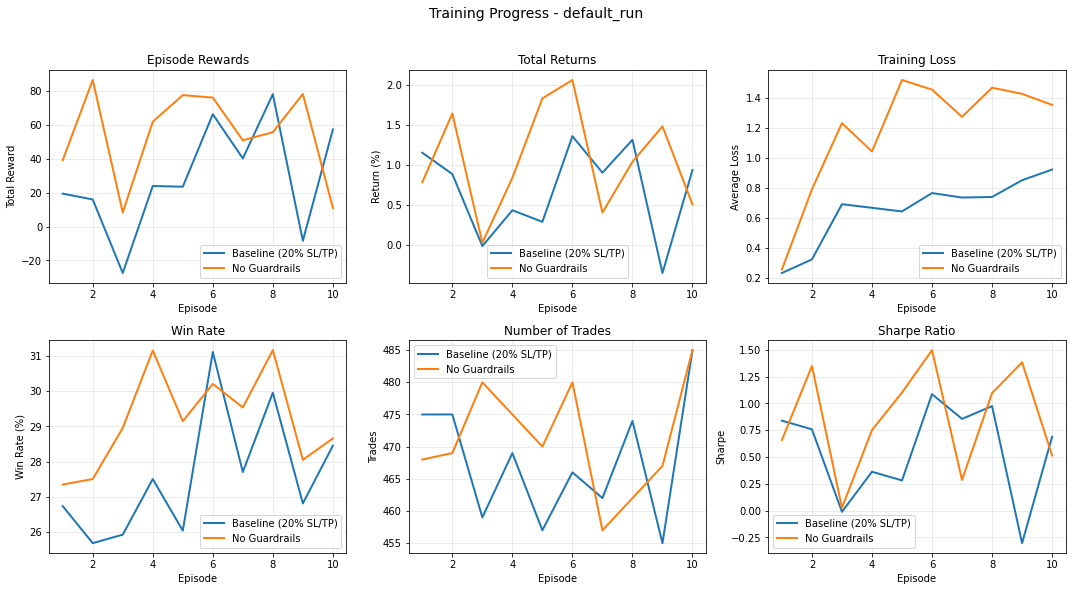

In [7]:
# Plot training progress for all strategies
if not TEST_MODE:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    for strategy_name, results in all_results.items():
        history = results['training_history']['training_history']
        if history:
            history_df = pd.DataFrame(history)

            # Episode rewards
            axes[0, 0].plot(history_df['episode'], history_df['reward'],
                          label=strategy_name, linewidth=2)
            axes[0, 0].set_title('Episode Rewards')
            axes[0, 0].set_xlabel('Episode')
            axes[0, 0].set_ylabel('Total Reward')
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].legend()

            # Total returns
            axes[0, 1].plot(history_df['episode'], history_df['return'] * 100,
                          label=strategy_name, linewidth=2)
            axes[0, 1].set_title('Total Returns')
            axes[0, 1].set_xlabel('Episode')
            axes[0, 1].set_ylabel('Return (%)')
            axes[0, 1].grid(True, alpha=0.3)
            axes[0, 1].legend()

            # Training Loss
            axes[0, 2].plot(history_df['episode'], history_df.get('avg_loss', 0),
                          label=strategy_name, linewidth=2)
            axes[0, 2].set_title('Training Loss')
            axes[0, 2].set_xlabel('Episode')
            axes[0, 2].set_ylabel('Average Loss')
            axes[0, 2].grid(True, alpha=0.3)
            axes[0, 2].legend()

            # Win rate
            axes[1, 0].plot(history_df['episode'], history_df['win_rate'] * 100,
                          label=strategy_name, linewidth=2)
            axes[1, 0].set_title('Win Rate')
            axes[1, 0].set_xlabel('Episode')
            axes[1, 0].set_ylabel('Win Rate (%)')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].legend()

            # Number of trades
            axes[1, 1].plot(history_df['episode'], history_df['trades'],
                          label=strategy_name, linewidth=2)
            axes[1, 1].set_title('Number of Trades')
            axes[1, 1].set_xlabel('Episode')
            axes[1, 1].set_ylabel('Trades')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend()

            # Sharpe Ratio
            axes[1, 2].plot(history_df['episode'], history_df['sharpe'],
                          label=strategy_name, linewidth=2)
            axes[1, 2].set_title('Sharpe Ratio')
            axes[1, 2].set_xlabel('Episode')
            axes[1, 2].set_ylabel('Sharpe')
            axes[1, 2].grid(True, alpha=0.3)
            axes[1, 2].legend()

    plt.suptitle(f'Training Progress - {PROJECT_FOLDER}', fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Save the plot
    plot_path = f"{results_dir}/training_progress.png"
    plt.savefig(plot_path, dpi=100, bbox_inches='tight')
    print(f"✅ Training progress plot saved to: {plot_path}")
    
    plt.show()
else:
    print("📊 Skipping training plots (TEST_MODE enabled)")

## 6. Out-of-Sample Validation Comparison

Compare all strategies across all validation periods.

In [8]:
# Validate all strategies on all periods
print(f"\n{'='*70}")
print(f"📊 OUT-OF-SAMPLE VALIDATION COMPARISON")
print(f"{'='*70}")
print(f"Validation periods: {len(validation_periods)}\n")

validation_results = {}

for strategy_name, results in all_results.items():
    print(f"\nValidating: {strategy_name}")
    trainer = results['trainer']

    period_metrics = []

    for i, val_period in enumerate(validation_periods, 1):
        print(f"  Period {i}: {val_period.index.min().date()} to {val_period.index.max().date()}", end=" ")

        val_env = TradingEnvironment(
            val_period,
            feature_columns,
            results['config'],
            mode='test'
        )

        val_metrics = trainer.evaluate(val_env, verbose=False)
        period_metrics.append({
            'period': i,
            'return': val_metrics.get('total_return', 0),
            'sharpe': val_metrics.get('sharpe_ratio', 0),
            'max_drawdown': val_metrics.get('max_drawdown', 0),
            'win_rate': val_metrics.get('win_rate', 0),
            'trades': val_metrics.get('num_trades', 0)
        })

        print(f"→ Return: {val_metrics.get('total_return', 0):.2%}")

    validation_results[strategy_name] = period_metrics

print(f"\n✅ Validation complete for all strategies")


📊 OUT-OF-SAMPLE VALIDATION COMPARISON
Validation periods: 5


Validating: Baseline (20% SL/TP)
  Period 1: 2022-10-03 to 2022-10-31 → Return: 0.09%
  Period 2: 2023-04-03 to 2023-04-28 → Return: -0.02%
  Period 3: 2023-11-01 to 2023-11-30 → Return: 0.09%
  Period 4: 2023-12-01 to 2023-12-29 → Return: 0.11%
  Period 5: 2024-02-01 to 2024-02-29 → Return: 0.12%

Validating: No Guardrails
  Period 1: 2022-10-03 to 2022-10-31 → Return: 0.08%
  Period 2: 2023-04-03 to 2023-04-28 → Return: 0.04%
  Period 3: 2023-11-01 to 2023-11-30 → Return: 0.08%
  Period 4: 2023-12-01 to 2023-12-29 → Return: 0.09%
  Period 5: 2024-02-01 to 2024-02-29 → Return: 0.06%

✅ Validation complete for all strategies


✅ Validation comparison plot saved to: results/default_run/run_20260119_092018/validation_comparison.png


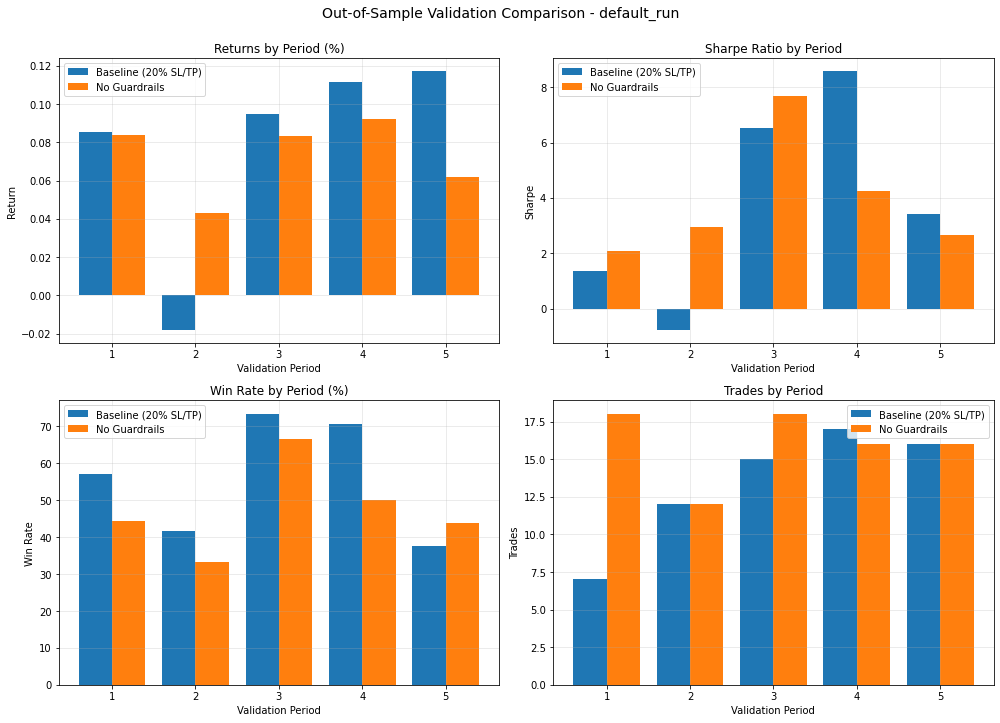

In [9]:
# Plot validation comparison
if len(validation_periods) > 0 and len(all_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    metrics_to_plot = [
        ('return', 'Returns by Period (%)', 0, 0, 100),
        ('sharpe', 'Sharpe Ratio by Period', 0, 1, 1),
        ('win_rate', 'Win Rate by Period (%)', 1, 0, 100),
        ('trades', 'Trades by Period', 1, 1, 1)
    ]

    for metric, title, row, col, multiplier in metrics_to_plot:
        ax = axes[row, col]

        x = np.arange(1, len(validation_periods) + 1)
        width = 0.8 / max(len(all_results), 1)

        for i, (strategy_name, period_metrics) in enumerate(validation_results.items()):
            values = [pm[metric] * multiplier for pm in period_metrics]
            offset = (i - len(all_results)/2 + 0.5) * width
            ax.bar(x + offset, values, width, label=strategy_name)

        ax.set_title(title)
        ax.set_xlabel('Validation Period')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_xticks(x)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'Out-of-Sample Validation Comparison - {PROJECT_FOLDER}', fontsize=14, y=1.00)
    plt.tight_layout()
    
    # Save the plot
    plot_path = f"{results_dir}/validation_comparison.png"
    plt.savefig(plot_path, dpi=100, bbox_inches='tight')
    print(f"✅ Validation comparison plot saved to: {plot_path}")
    
    plt.show()
else:
    print("📊 No validation periods to plot")

## 7. Test Set Comparison

Compare all strategies on the held-out test period.

In [10]:
# Test all strategies
print(f"\n{'='*70}")
print(f"🧪 FINAL TEST COMPARISON")
print(f"{'='*70}")
print(f"Test period: {test_data.index.min().date()} to {test_data.index.max().date()}")
print(f"Test samples: {len(test_data)}\n")

test_results = {}
metrics_calc = PerformanceMetrics()

for strategy_name, results in all_results.items():
    print(f"Testing: {strategy_name}")
    trainer = results['trainer']

    test_env = TradingEnvironment(
        test_data,
        feature_columns,
        results['config'],
        mode='test'
    )

    test_metrics = trainer.evaluate(test_env, verbose=False)
    comprehensive_metrics = metrics_calc.calculate_metrics(
        test_env.portfolio_values,
        test_env.trades,
        test_env.starting_balance
    )

    test_results[strategy_name] = {
        'metrics': comprehensive_metrics,
        'portfolio_values': test_env.portfolio_values.copy(),
        'trades': test_env.trades.copy()
    }

    print(f"  Return: {comprehensive_metrics['total_return']:.2%}")
    print(f"  Sharpe: {comprehensive_metrics['sharpe_ratio']:.2f}")
    print(f"  Win Rate: {comprehensive_metrics['win_rate']:.2%}\n")

print(f"✅ Test evaluation complete for all strategies")


🧪 FINAL TEST COMPARISON
Test period: 2025-06-30 to 2025-12-30
Test samples: 128

Testing: Baseline (20% SL/TP)
  Return: 0.50%
  Sharpe: 1.68
  Win Rate: 73.33%

Testing: No Guardrails
  Return: 0.32%
  Sharpe: 1.26
  Win Rate: 73.68%

✅ Test evaluation complete for all strategies


In [11]:
# Test comparison table
comparison_data = []
for strategy_name, result in test_results.items():
    m = result['metrics']
    comparison_data.append({
        'Strategy': strategy_name,
        'Return (%)': f"{m['total_return']*100:.2f}",
        'Sharpe': f"{m['sharpe_ratio']:.2f}",
        'Max DD (%)': f"{m['max_drawdown']*100:.2f}",
        'Win Rate (%)': f"{m['win_rate']*100:.2f}",
        'Trades': m['num_trades']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("📊 TEST RESULTS SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


📊 TEST RESULTS SUMMARY
            Strategy Return (%) Sharpe Max DD (%) Win Rate (%)  Trades
Baseline (20% SL/TP)       0.50   1.68      -0.30        73.33      45
       No Guardrails       0.32   1.26      -0.20        73.68      57


✅ Test portfolio comparison saved to: results/default_run/run_20260119_092018/test_portfolio_values.png


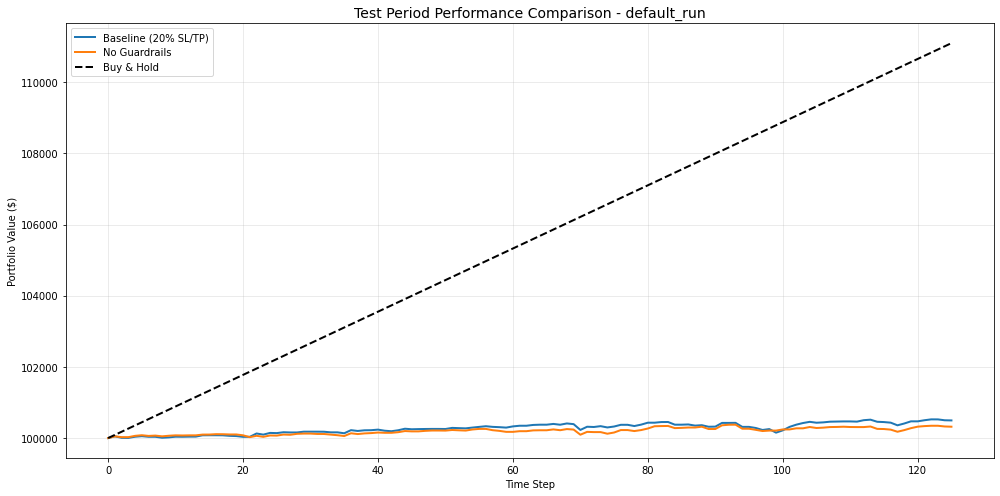

In [12]:
# Plot test comparison - Portfolio values over time
fig, ax = plt.subplots(figsize=(14, 7))

for strategy_name, result in test_results.items():
    ax.plot(result['portfolio_values'], label=strategy_name, linewidth=2)

# Add buy & hold
price_col = f"{ticker}_Close_orig"
window_size = data_config.config['data']['window_size']
initial_price = test_data.iloc[window_size][price_col]
final_price = test_data.iloc[-1][price_col]
buy_hold_return = (final_price - initial_price) / initial_price
starting_balance = list(all_results.values())[0]['config']['trading']['starting_balance']

buy_hold_values = [starting_balance * (1 + buy_hold_return * i / len(test_data))
                   for i in range(len(test_results[list(test_results.keys())[0]]['portfolio_values']))]
ax.plot(buy_hold_values, label='Buy & Hold', linewidth=2, linestyle='--', color='black')

ax.set_title(f'Test Period Performance Comparison - {PROJECT_FOLDER}', fontsize=14)
ax.set_xlabel('Time Step')
ax.set_ylabel('Portfolio Value ($)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
plot_path = f"{results_dir}/test_portfolio_values.png"
plt.savefig(plot_path, dpi=100, bbox_inches='tight')
print(f"✅ Test portfolio comparison saved to: {plot_path}")

plt.show()

✅ Test metrics comparison saved to: results/default_run/run_20260119_092018/test_metrics_comparison.png


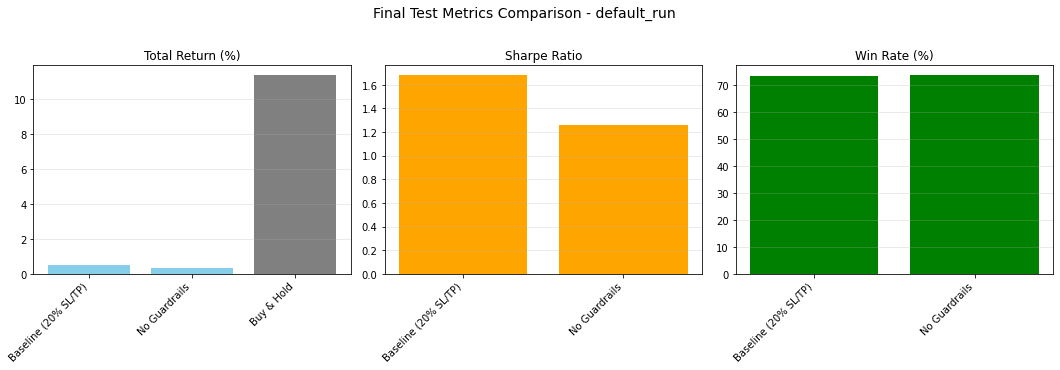

In [13]:
# Final comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

strategies = list(test_results.keys())
returns = [test_results[s]['metrics']['total_return'] * 100 for s in strategies]
sharpes = [test_results[s]['metrics']['sharpe_ratio'] for s in strategies]
win_rates = [test_results[s]['metrics']['win_rate'] * 100 for s in strategies]

# Add buy & hold to comparison
strategies_with_bh = strategies + ['Buy & Hold']
returns_with_bh = returns + [buy_hold_return * 100]

x = np.arange(len(strategies))
x_with_bh = np.arange(len(strategies_with_bh))

axes[0].bar(x_with_bh, returns_with_bh, color=['skyblue']*len(strategies) + ['gray'])
axes[0].set_title('Total Return (%)')
axes[0].set_xticks(x_with_bh)
axes[0].set_xticklabels(strategies_with_bh, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x, sharpes, color='orange')
axes[1].set_title('Sharpe Ratio')
axes[1].set_xticks(x)
axes[1].set_xticklabels(strategies, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(x, win_rates, color='green')
axes[2].set_title('Win Rate (%)')
axes[2].set_xticks(x)
axes[2].set_xticklabels(strategies, rotation=45, ha='right')
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Final Test Metrics Comparison - {PROJECT_FOLDER}', fontsize=14, y=1.02)
plt.tight_layout()

# Save the plot
plot_path = f"{results_dir}/test_metrics_comparison.png"
plt.savefig(plot_path, dpi=100, bbox_inches='tight')
print(f"✅ Test metrics comparison saved to: {plot_path}")

plt.show()

## 8. Save Final Results

In [14]:
# Save final results data (plots already saved above)
# Note: results_dir was created in cell 3

# Save CSV comparison
comparison_df.to_csv(f"{results_dir}/test_comparison.csv", index=False)

# Save comprehensive results
final_results = {
    'timestamp': datetime.now().isoformat(),
    'project': PROJECT_FOLDER,
    'test_mode': TEST_MODE,
    'run_name': run_name,
    'data_config': data_config.config,
    'strategies': {},
    'validation_results': validation_results,
    'test_results': {k: v['metrics'] for k, v in test_results.items()},
    'buy_hold_return': float(buy_hold_return)
}

for strategy_name, results in all_results.items():
    final_results['strategies'][strategy_name] = {
        'experiment_name': results['experiment_name'],
        'config': results['config'],
        'training_history': results['training_history']['training_history']
    }

# Save to JSON
results_path = f"{results_dir}/final_results.json"
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\n{'='*70}")
print(f"✅ COMPLETE PIPELINE FINISHED!")
print(f"{'='*70}")
print(f"📁 Project: {PROJECT_FOLDER}")
print(f"📝 Run name: {run_name}")
print(f"📊 Strategies trained: {len(trading_configs)}")
print(f"📈 Results saved to: {results_dir}/")
print(f"📄 Final results: {results_path}")

# List saved files
saved_files = os.listdir(results_dir)
saved_files.sort()
print(f"\n📁 Saved files:")
for file in saved_files:
    size_kb = os.path.getsize(f"{results_dir}/{file}") / 1024
    file_type = "📊 Plot" if file.endswith('.png') else "📄 Data" if file.endswith('.csv') else "📋 Results"
    print(f"   {file_type}: {file} ({size_kb:.1f} KB)")

# Count plots saved
plot_files = [f for f in saved_files if f.endswith('.png')]
print(f"\n📊 Plots saved: {len(plot_files)}")

# Show best strategy
if test_results:
    print(f"\n🏆 Best performing strategy:")
    best_strategy = max(test_results.items(), key=lambda x: x[1]['metrics']['total_return'])
    print(f"   {best_strategy[0]}")
    print(f"   • Return: {best_strategy[1]['metrics']['total_return']:.2%}")
    print(f"   • Sharpe: {best_strategy[1]['metrics']['sharpe_ratio']:.2f}")
    print(f"   • vs Buy & Hold: {(best_strategy[1]['metrics']['total_return'] - buy_hold_return):.2%}")

print(f"{'='*70}")

# Print final summary
logger.print_summary()


✅ COMPLETE PIPELINE FINISHED!
📁 Project: default_run
📝 Run name: default_run_SPY_20260119_092018
📊 Strategies trained: 2
📈 Results saved to: results/default_run/run_20260119_092018/
📄 Final results: results/default_run/run_20260119_092018/final_results.json

📁 Saved files:
   📋 Results: final_results.json (24.0 KB)
   📄 Data: test_comparison.csv (0.1 KB)
   📊 Plot: test_metrics_comparison.png (31.5 KB)
   📊 Plot: test_portfolio_values.png (59.2 KB)
   📊 Plot: training_progress.png (195.6 KB)
   📊 Plot: validation_comparison.png (61.2 KB)

📊 Plots saved: 4

🏆 Best performing strategy:
   Baseline (20% SL/TP)
   • Return: 0.50%
   • Sharpe: 1.68
   • vs Buy & Hold: -10.87%

RUN SUMMARY: default_run_SPY_20260119_092018

Stages Completed: 6
  • Data Collection: 0.8s
  • Feature Engineering: 0.0s
  • Data Normalization: 0.0s
  • Data Splitting: 0.1s
  • Training: Baseline (20% SL/TP): 19.8s
  • Training: No Guardrails: 19.5s

Latest Training Metrics:
  • reward: 11.0187
  • return: 0.0051
